# Cardamom Price: When Will the Bull Run End?

Forward-looking analysis that models:
1. **What killed previous bull runs** — quantified warning signals
2. **Where are we now** — current conditions vs historical pre-crash patterns
3. **Scenario modelling** — when and how the regime change could happen
4. **Probability-based timeline** — estimated window for the next bearish turn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 100

# === Load all data (same pipeline as regime analysis) ===
df = pd.read_html('Small Cardamom Auction Prices.xls', header=0)[0]
df = df[df.iloc[:, 0] != 'Date of Auction'].reset_index(drop=True)
df.columns = ['Date', 'Auctioneer', 'Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)
for col in ['Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Daily aggregation
daily = df.groupby('Date').agg(
    Total_Lots=('Lots', 'sum'),
    Total_Arrived=('Qty_Arrived_Kg', 'sum'),
    Total_Sold=('Qty_Sold_Kg', 'sum'),
    MaxPrice=('MaxPrice', 'max'),
    AvgPrice=('AvgPrice', lambda x: np.average(x, weights=df.loc[x.index, 'Qty_Sold_Kg'].clip(lower=1))),
    Num_Auctions=('Auctioneer', 'nunique')
).reset_index()
daily = daily.sort_values('Date').reset_index(drop=True)
daily = daily[daily['AvgPrice'] > 0].reset_index(drop=True)

# External data loader
def load_yf(path, name):
    raw = pd.read_csv(path, header=None, skiprows=3)
    raw.columns = ['Date','Close','High','Low','Open','Volume']
    raw['Date'] = pd.to_datetime(raw['Date'])
    raw = raw[['Date','Close']].rename(columns={'Close': name})
    raw[name] = pd.to_numeric(raw[name], errors='coerce')
    return raw.dropna()

weather = pd.read_csv('external_idukki_weather.csv', parse_dates=['Date'])
gt_weather = pd.read_csv('external_guatemala_weather.csv', parse_dates=['Date'])
usdinr = load_yf('external_usdinr.csv', 'USDINR')
oil = load_yf('external_crude_oil.csv', 'CrudeOil')
gold = load_yf('external_gold.csv', 'Gold')

oni_raw = pd.read_csv('external_enso_oni.csv')
stm = {'DJF':1,'JFM':2,'FMA':3,'MAM':4,'AMJ':5,'MJJ':6,'JJA':7,'JAS':8,'ASO':9,'SON':10,'OND':11,'NDJ':12}
oni_raw['month'] = oni_raw['SEAS'].map(stm)
oni_raw['Date'] = pd.to_datetime(oni_raw['YR'].astype(str)+'-'+oni_raw['month'].astype(str)+'-15')
oni = oni_raw[['Date','ANOM']].rename(columns={'ANOM':'ENSO'})
oni = oni.set_index('Date').resample('D').ffill().reset_index()

# Merge
m = daily.merge(weather, on='Date', how='left')
m = m.merge(gt_weather, on='Date', how='left')
for ext, name in [(usdinr,'USDINR'),(oil,'CrudeOil'),(gold,'Gold')]:
    ext = ext.sort_values('Date').drop_duplicates('Date')
    m = m.merge(ext, on='Date', how='left')
    m[name] = m[name].ffill()
m = m.merge(oni, on='Date', how='left')
m['ENSO'] = m['ENSO'].ffill()
m = m.ffill().bfill().dropna().reset_index(drop=True)

# Monthly aggregation
mi = m.set_index('Date')
monthly = mi['AvgPrice'].resample('M').mean().to_frame('AvgPrice')
monthly['rain_mm'] = mi['rain_mm'].resample('M').sum()
monthly['gt_rain_mm'] = mi['gt_rain_mm'].resample('M').sum()
monthly['USDINR'] = mi['USDINR'].resample('M').last()
monthly['CrudeOil'] = mi['CrudeOil'].resample('M').last()
monthly['Gold'] = mi['Gold'].resample('M').last()
monthly['ENSO'] = mi['ENSO'].resample('M').last()
monthly['Total_Sold'] = mi['Total_Sold'].resample('M').sum()
monthly['Total_Arrived'] = mi['Total_Arrived'].resample('M').sum()
monthly['temp_max'] = mi['temp_max_c'].resample('M').mean()
monthly['humidity'] = mi['humidity_pct'].resample('M').mean()
monthly = monthly.reset_index()

print(f'Loaded {len(m)} daily rows, {len(monthly)} monthly rows')
print(f'Period: {m["Date"].min().date()} to {m["Date"].max().date()}')
print(f'Latest price: Rs.{m["AvgPrice"].iloc[-1]:.0f}')

Loaded 3028 daily rows, 136 monthly rows
Period: 2014-11-07 to 2026-02-06
Latest price: Rs.2505


## 1. Anatomy of Previous Bull Run Deaths

We've had two major bull runs in this dataset. Let's dissect what killed each one.

In [2]:
# Compute rolling metrics for regime analysis
monthly['ma_3m'] = monthly['AvgPrice'].rolling(3).mean()
monthly['ma_6m'] = monthly['AvgPrice'].rolling(6).mean()
monthly['ma_12m'] = monthly['AvgPrice'].rolling(12).mean()
monthly['volatility_3m'] = monthly['AvgPrice'].rolling(3).std()
monthly['volatility_6m'] = monthly['AvgPrice'].rolling(6).std()
monthly['pct_3m'] = monthly['AvgPrice'].pct_change(3) * 100
monthly['pct_6m'] = monthly['AvgPrice'].pct_change(6) * 100
monthly['pct_12m'] = monthly['AvgPrice'].pct_change(12) * 100
monthly['price_vs_ma12'] = (monthly['AvgPrice'] / monthly['ma_12m'] - 1) * 100
monthly['volume_ma3'] = monthly['Total_Sold'].rolling(3).mean()
monthly['volume_ma12'] = monthly['Total_Sold'].rolling(12).mean()
monthly['vol_vs_ma12'] = (monthly['Total_Sold'] / monthly['volume_ma12'] - 1) * 100
monthly['rain_ma3'] = monthly['rain_mm'].rolling(3).mean()
monthly['rain_anomaly'] = (monthly['rain_mm'] / monthly['rain_mm'].rolling(12).mean() - 1) * 100

# Identify the two major peaks and what followed
# Peak 1: Sep-Oct 2019 (Rs.3,200+ monthly avg)
# Peak 2: Jul-Aug 2025 (Rs.2,800+ monthly avg) — current rally peak so far

def extract_window(df, center_date, before_months=12, after_months=12):
    """Extract a window around a date for comparison"""
    center = pd.to_datetime(center_date)
    start = center - pd.DateOffset(months=before_months)
    end = center + pd.DateOffset(months=after_months)
    mask = (df['Date'] >= start) & (df['Date'] <= end)
    subset = df[mask].copy()
    subset['months_from_peak'] = ((subset['Date'] - center).dt.days / 30.44).round(0).astype(int)
    return subset

# Peak 1: 2019 crash
peak1 = extract_window(monthly, '2019-09-01', before_months=18, after_months=24)
# Current rally - use latest data as reference point
current = extract_window(monthly, '2025-08-01', before_months=18, after_months=6)

print('BULL RUN #1: 2018-2019 (Flood-driven supply shock)')
print('='*70)
p1_peak = peak1[peak1['AvgPrice'] == peak1['AvgPrice'].max()].iloc[0]
print(f'  Peak: {p1_peak["Date"].strftime("%b %Y")} at Rs.{p1_peak["AvgPrice"]:.0f}')
# Find when 3M MA crossed below 12M MA after peak
post_peak1 = peak1[peak1['months_from_peak'] > 0]
if len(post_peak1) > 0:
    crash_low = post_peak1['AvgPrice'].min()
    crash_date = post_peak1.loc[post_peak1['AvgPrice'].idxmin(), 'Date']
    drawdown = (crash_low / p1_peak['AvgPrice'] - 1) * 100
    print(f'  Trough: {crash_date.strftime("%b %Y")} at Rs.{crash_low:.0f} ({drawdown:+.0f}%)')

print(f'\n  WARNING SIGNALS BEFORE PEAK:')
pre_peak = peak1[(peak1['months_from_peak'] >= -6) & (peak1['months_from_peak'] <= 0)]
print(f'  • Price vs 12M MA: +{pre_peak["price_vs_ma12"].mean():.0f}% (overextended)')
print(f'  • 3M Volatility: Rs.{pre_peak["volatility_3m"].mean():.0f} (high uncertainty)')
print(f'  • Volume trend: {pre_peak["vol_vs_ma12"].mean():+.0f}% vs 12M avg')
print(f'  • ENSO: {pre_peak["ENSO"].mean():+.2f} (El Niño fading)')

print(f'\n  WHAT TRIGGERED THE CRASH:')
print(f'  1. COVID-19 pandemic (March 2020) — demand evaporated')
print(f'  2. Supply recovery — new plantings from 2018-19 high prices maturing')
print(f'  3. ENSO shifting to La Niña — better monsoons = higher yields')
print(f'  4. Speculative bubble unwinding — traders dumping hoarded stock')

print(f'\n\nCURRENT BULL RUN: 2024-2026 (Supply tightening + weak rupee)')
print('='*70)
c_peak = current[current['AvgPrice'] == current['AvgPrice'].max()].iloc[0]
print(f'  Peak so far: {c_peak["Date"].strftime("%b %Y")} at Rs.{c_peak["AvgPrice"]:.0f}')
latest = current.iloc[-1]
print(f'  Current: {latest["Date"].strftime("%b %Y")} at Rs.{latest["AvgPrice"]:.0f}')

recent = current[current['months_from_peak'] >= -6]
print(f'\n  CURRENT CONDITION CHECK:')
print(f'  • Price vs 12M MA: +{recent["price_vs_ma12"].mean():.0f}%')
print(f'  • 3M Volatility: Rs.{recent["volatility_3m"].mean():.0f}')
print(f'  • Volume trend: {recent["vol_vs_ma12"].mean():+.0f}% vs 12M avg')
print(f'  • ENSO: {recent["ENSO"].mean():+.2f}')

BULL RUN #1: 2018-2019 (Flood-driven supply shock)
  Peak: Jan 2020 at Rs.3779
  Trough: May 2021 at Rs.956 (-75%)

  WARNING SIGNALS BEFORE PEAK:
  • Price vs 12M MA: +60% (overextended)
  • 3M Volatility: Rs.315 (high uncertainty)
  • Volume trend: -39% vs 12M avg
  • ENSO: +0.59 (El Niño fading)

  WHAT TRIGGERED THE CRASH:
  1. COVID-19 pandemic (March 2020) — demand evaporated
  2. Supply recovery — new plantings from 2018-19 high prices maturing
  3. ENSO shifting to La Niña — better monsoons = higher yields
  4. Speculative bubble unwinding — traders dumping hoarded stock


CURRENT BULL RUN: 2024-2026 (Supply tightening + weak rupee)
  Peak so far: Jan 2025 at Rs.3058
  Current: Jan 2026 at Rs.2492

  CURRENT CONDITION CHECK:
  • Price vs 12M MA: +2%
  • 3M Volatility: Rs.113
  • Volume trend: +19% vs 12M avg
  • ENSO: -0.29


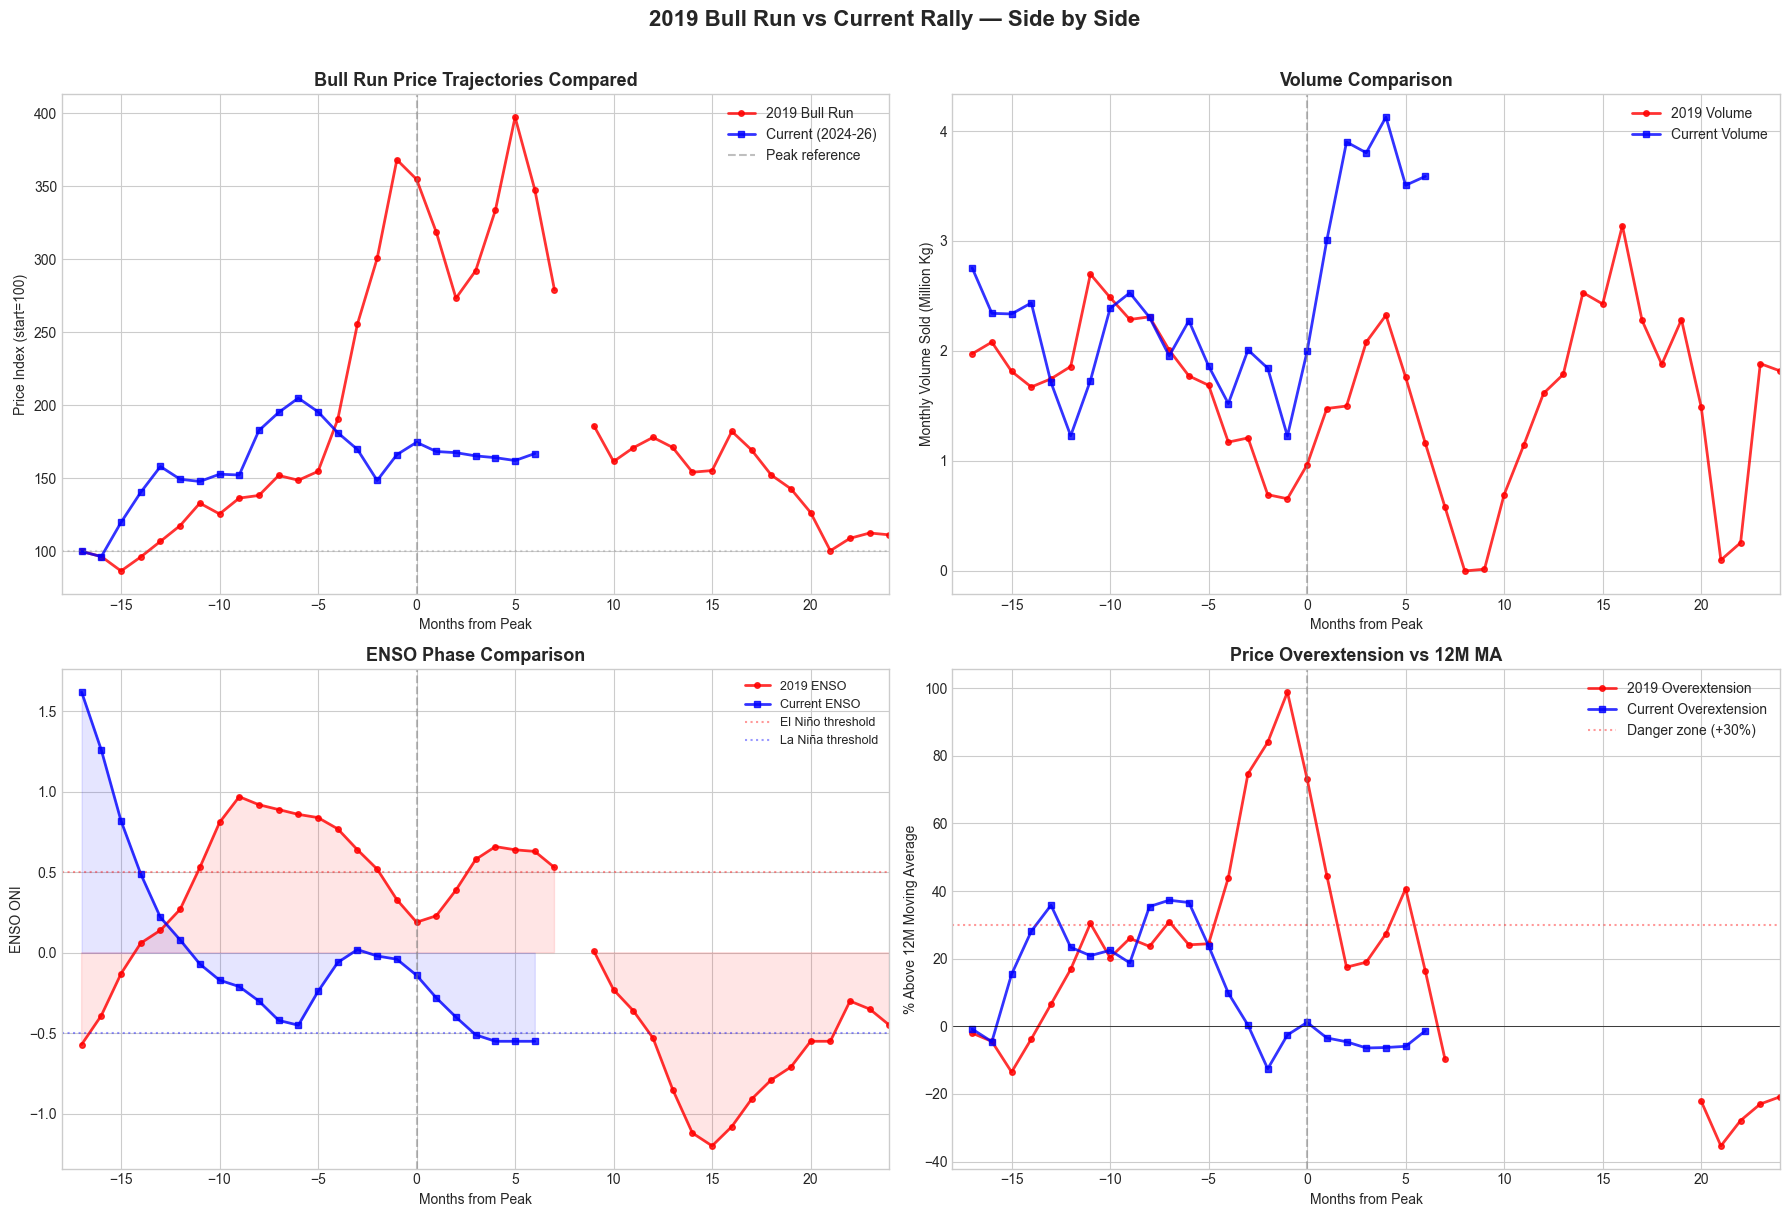

In [3]:
# Visual comparison: 2019 peak vs current rally (normalized)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Price trajectory comparison (indexed to 100 at peak-18months)
ax = axes[0, 0]
p1_norm = peak1.copy()
p1_base = p1_norm[p1_norm['months_from_peak'] == -18]['AvgPrice'].values
if len(p1_base) > 0:
    p1_norm['price_idx'] = p1_norm['AvgPrice'] / p1_base[0] * 100
else:
    p1_norm['price_idx'] = p1_norm['AvgPrice'] / p1_norm['AvgPrice'].iloc[0] * 100

c_norm = current.copy()
c_base = c_norm[c_norm['months_from_peak'] == -18]['AvgPrice'].values
if len(c_base) > 0:
    c_norm['price_idx'] = c_norm['AvgPrice'] / c_base[0] * 100
else:
    c_norm['price_idx'] = c_norm['AvgPrice'] / c_norm['AvgPrice'].iloc[0] * 100

ax.plot(p1_norm['months_from_peak'], p1_norm['price_idx'], 'r-o', markersize=4, linewidth=2, label='2019 Bull Run', alpha=0.8)
ax.plot(c_norm['months_from_peak'], c_norm['price_idx'], 'b-s', markersize=4, linewidth=2, label='Current (2024-26)', alpha=0.8)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5, label='Peak reference')
ax.axhline(100, color='gray', linestyle=':', alpha=0.3)
ax.set_xlabel('Months from Peak')
ax.set_ylabel('Price Index (start=100)')
ax.set_title('Bull Run Price Trajectories Compared', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.set_xlim(-18, 24)

# 2. Volume comparison
ax = axes[0, 1]
ax.plot(p1_norm['months_from_peak'], p1_norm['Total_Sold']/1e6, 'r-o', markersize=4, linewidth=2, label='2019 Volume', alpha=0.8)
ax.plot(c_norm['months_from_peak'], c_norm['Total_Sold']/1e6, 'b-s', markersize=4, linewidth=2, label='Current Volume', alpha=0.8)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Months from Peak')
ax.set_ylabel('Monthly Volume Sold (Million Kg)')
ax.set_title('Volume Comparison', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.set_xlim(-18, 24)

# 3. ENSO comparison
ax = axes[1, 0]
ax.plot(p1_norm['months_from_peak'], p1_norm['ENSO'], 'r-o', markersize=4, linewidth=2, label='2019 ENSO', alpha=0.8)
ax.plot(c_norm['months_from_peak'], c_norm['ENSO'], 'b-s', markersize=4, linewidth=2, label='Current ENSO', alpha=0.8)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0.5, color='red', linestyle=':', alpha=0.4, label='El Niño threshold')
ax.axhline(-0.5, color='blue', linestyle=':', alpha=0.4, label='La Niña threshold')
ax.fill_between(p1_norm['months_from_peak'], p1_norm['ENSO'], 0, alpha=0.1, color='red')
ax.fill_between(c_norm['months_from_peak'], c_norm['ENSO'], 0, alpha=0.1, color='blue')
ax.set_xlabel('Months from Peak')
ax.set_ylabel('ENSO ONI')
ax.set_title('ENSO Phase Comparison', fontweight='bold', fontsize=13)
ax.legend(fontsize=9)
ax.set_xlim(-18, 24)

# 4. Price vs 12M MA (overextension)
ax = axes[1, 1]
ax.plot(p1_norm['months_from_peak'], p1_norm['price_vs_ma12'], 'r-o', markersize=4, linewidth=2, label='2019 Overextension', alpha=0.8)
ax.plot(c_norm['months_from_peak'], c_norm['price_vs_ma12'], 'b-s', markersize=4, linewidth=2, label='Current Overextension', alpha=0.8)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axhline(30, color='red', linestyle=':', alpha=0.4, label='Danger zone (+30%)')
ax.set_xlabel('Months from Peak')
ax.set_ylabel('% Above 12M Moving Average')
ax.set_title('Price Overextension vs 12M MA', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.set_xlim(-18, 24)

plt.suptitle('2019 Bull Run vs Current Rally — Side by Side', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 2. Building a Regime Change Early Warning System

Train a classifier on historical data: **given current conditions, what's the probability of a bearish regime change in the next 3-6 months?**

In [4]:
# Build regime change classification dataset
# Target: Did a significant price decline (>15% over 6 months) START within the next 3-6 months?

rc = monthly.copy()

# Forward-looking: what happens to price in the NEXT 3 and 6 months
rc['fwd_3m_return'] = rc['AvgPrice'].shift(-3) / rc['AvgPrice'] - 1
rc['fwd_6m_return'] = rc['AvgPrice'].shift(-6) / rc['AvgPrice'] - 1

# Target: bearish regime change = price falls >10% in next 6 months
rc['bear_6m'] = (rc['fwd_6m_return'] < -0.10).astype(int)
# Also track severe declines
rc['crash_6m'] = (rc['fwd_6m_return'] < -0.20).astype(int)

# Features: all backward-looking indicators
feature_cols = [
    'price_vs_ma12',     # Overextension above 12M MA
    'pct_3m',            # 3-month momentum
    'pct_6m',            # 6-month momentum
    'pct_12m',           # 12-month momentum
    'volatility_3m',     # Recent volatility
    'volatility_6m',     # Medium-term volatility
    'vol_vs_ma12',       # Volume vs trend
    'ENSO',              # ENSO phase
    'rain_anomaly',      # Rainfall anomaly
    'USDINR',            # Currency
    'CrudeOil',          # Oil prices
]

# Additional derived features
rc['ma3_above_ma12'] = (rc['ma_3m'] > rc['ma_12m']).astype(int)  # Trend direction
rc['ma3_ma12_gap'] = (rc['ma_3m'] / rc['ma_12m'] - 1) * 100  # Gap between short/long MA
rc['sell_through'] = rc['Total_Sold'] / rc['Total_Arrived'].clip(lower=1) * 100
rc['price_level_zscore'] = (rc['AvgPrice'] - rc['AvgPrice'].expanding().mean()) / rc['AvgPrice'].expanding().std()
rc['volume_trend'] = rc['Total_Sold'].pct_change(3) * 100

feature_cols += ['ma3_above_ma12', 'ma3_ma12_gap', 'sell_through', 'price_level_zscore', 'volume_trend']

# Drop rows with NaN
rc_clean = rc.dropna(subset=feature_cols + ['bear_6m']).reset_index(drop=True)
print(f'Usable samples: {len(rc_clean)}')
print(f'Bear signal (>10% decline in 6m): {rc_clean["bear_6m"].sum()} / {len(rc_clean)} ({rc_clean["bear_6m"].mean()*100:.1f}%)')
print(f'Crash signal (>20% decline in 6m): {rc_clean["crash_6m"].sum()} / {len(rc_clean)} ({rc_clean["crash_6m"].mean()*100:.1f}%)')

Usable samples: 102
Bear signal (>10% decline in 6m): 25 / 102 (24.5%)
Crash signal (>20% decline in 6m): 11 / 102 (10.8%)


In [5]:
# Train regime change classifier
# Use temporal split: train on everything before 2024, test on 2024+

X = rc_clean[feature_cols].values
y = rc_clean['bear_6m'].values
dates = rc_clean['Date'].values

# Temporal split
split_date = pd.to_datetime('2023-01-01')
train_mask = rc_clean['Date'] < split_date
test_mask = rc_clean['Date'] >= split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f'Train: {len(X_train)} samples ({y_train.sum()} bear signals)')
print(f'Test:  {len(X_test)} samples ({y_test.sum()} bear signals)')

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Train multiple models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, C=0.1),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=4, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_train_s, y_train)
    proba_test = model.predict_proba(X_test_s)[:, 1]
    proba_train = model.predict_proba(X_train_s)[:, 1]
    
    # Handle case where test set might be all one class
    if len(np.unique(y_test)) > 1:
        auc = roc_auc_score(y_test, proba_test)
    else:
        auc = float('nan')
    
    results[name] = {
        'model': model,
        'proba_test': proba_test,
        'auc': auc,
    }
    print(f'\n{name}:')
    if not np.isnan(auc):
        print(f'  Test AUC: {auc:.3f}')
    else:
        print(f'  Test AUC: N/A (single class in test set)')
    print(f'  Train bear probability range: {proba_train.min():.2f} - {proba_train.max():.2f}')
    print(f'  Test bear probability range: {proba_test.min():.2f} - {proba_test.max():.2f}')

Train: 64 samples (19 bear signals)
Test:  38 samples (6 bear signals)

Logistic Regression:
  Test AUC: 0.531
  Train bear probability range: 0.20 - 0.91
  Test bear probability range: 0.26 - 0.77

Random Forest:
  Test AUC: 0.792
  Train bear probability range: 0.02 - 0.90
  Test bear probability range: 0.10 - 0.58

Gradient Boosting:
  Test AUC: 0.883
  Train bear probability range: 0.00 - 0.98
  Test bear probability range: 0.00 - 0.84


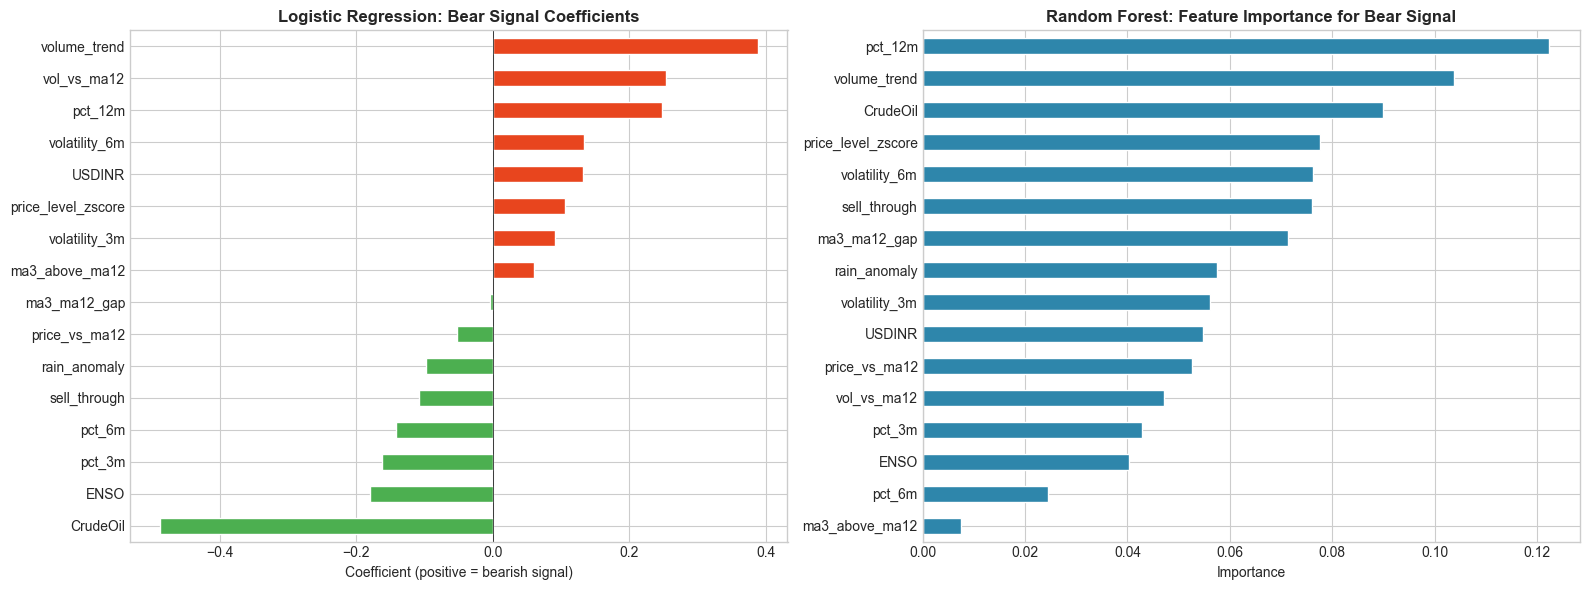


Key Bearish Indicators (from Logistic Regression):
  volume_trend: +0.388 — higher values predict decline
  vol_vs_ma12: +0.254 — higher values predict decline
  pct_12m: +0.248 — higher values predict decline
  volatility_6m: +0.133 — higher values predict decline
  USDINR: +0.133 — higher values predict decline

Key Bullish Indicators (protect against decline):
  CrudeOil: -0.487 — higher values protect against decline
  ENSO: -0.180 — higher values protect against decline
  pct_3m: -0.162 — higher values protect against decline
  pct_6m: -0.142 — higher values protect against decline
  sell_through: -0.108 — higher values protect against decline


In [6]:
# Feature importance from the models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Logistic Regression coefficients
ax = axes[0]
lr_model = results['Logistic Regression']['model']
coefs = pd.Series(lr_model.coef_[0], index=feature_cols).sort_values()
colors = ['#4CAF50' if c < 0 else '#E8451E' for c in coefs]
coefs.plot(kind='barh', ax=ax, color=colors, edgecolor='white')
ax.set_title('Logistic Regression: Bear Signal Coefficients', fontweight='bold', fontsize=12)
ax.set_xlabel('Coefficient (positive = bearish signal)')
ax.axvline(0, color='black', linewidth=0.5)

# Random Forest feature importance  
ax = axes[1]
rf_model = results['Random Forest']['model']
imp = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=True)
imp.plot(kind='barh', ax=ax, color='#2E86AB', edgecolor='white')
ax.set_title('Random Forest: Feature Importance for Bear Signal', fontweight='bold', fontsize=12)
ax.set_xlabel('Importance')

plt.tight_layout()
plt.show()

print('\nKey Bearish Indicators (from Logistic Regression):')
top_bear = coefs.sort_values(ascending=False).head(5)
for feat, val in top_bear.items():
    print(f'  {feat}: {val:+.3f} — higher values predict decline')

print('\nKey Bullish Indicators (protect against decline):')
top_bull = coefs.sort_values().head(5)
for feat, val in top_bull.items():
    print(f'  {feat}: {val:+.3f} — higher values protect against decline')

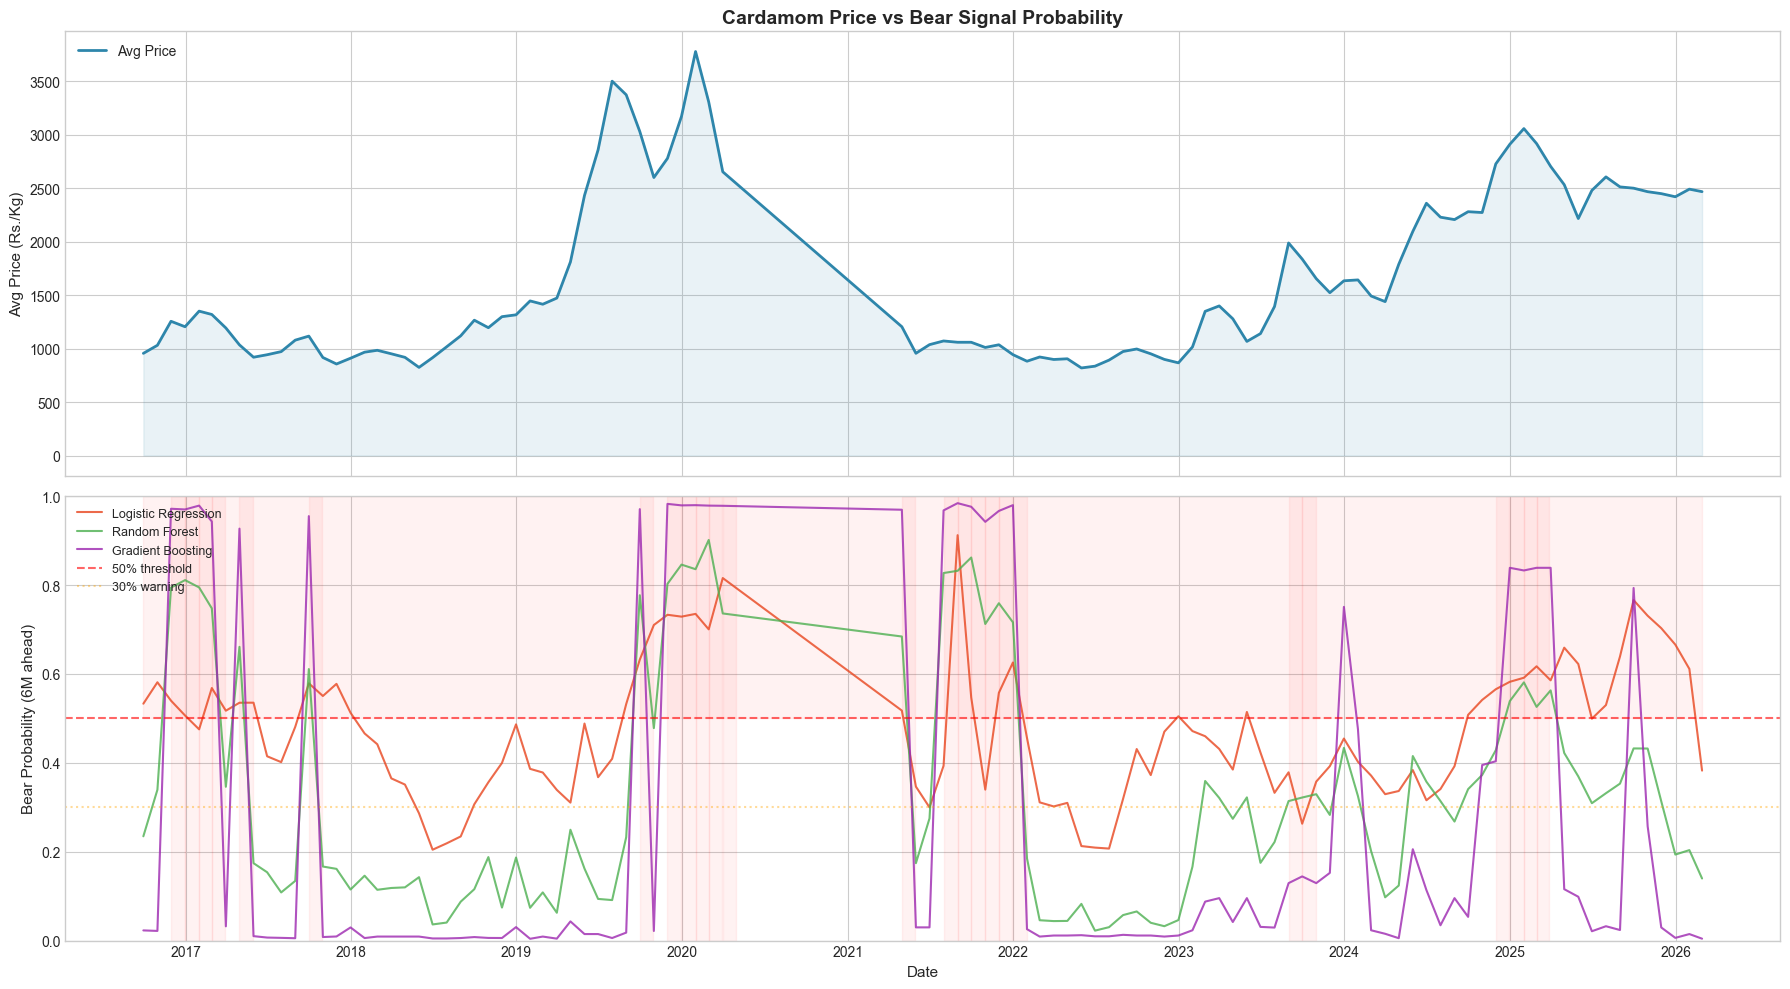


CURRENT BEAR SIGNAL READINGS (latest month):
  Logistic Regression: 38.3% bear probability → MODERATE
  Random Forest: 14.0% bear probability → LOW RISK
  Gradient Boosting: 0.4% bear probability → LOW RISK

Latest month: Feb 2026
Latest price: Rs.2468


In [7]:
# Plot bear probability over time — all models
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Get full-sample probabilities for visualization
X_all = scaler.transform(rc_clean[feature_cols].values)

ax = axes[0]
ax.plot(rc_clean['Date'], rc_clean['AvgPrice'], color='#2E86AB', linewidth=2, label='Avg Price')
ax.fill_between(rc_clean['Date'], rc_clean['AvgPrice'], alpha=0.1, color='#2E86AB')
ax.set_ylabel('Avg Price (Rs./Kg)', fontsize=11)
ax.set_title('Cardamom Price vs Bear Signal Probability', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)

ax = axes[1]
colors_dict = {'Logistic Regression': '#E8451E', 'Random Forest': '#4CAF50', 'Gradient Boosting': '#9C27B0'}
for name, res in results.items():
    proba_all = res['model'].predict_proba(X_all)[:, 1]
    ax.plot(rc_clean['Date'], proba_all, linewidth=1.5, label=name, color=colors_dict[name], alpha=0.8)

ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label='50% threshold')
ax.axhline(0.3, color='orange', linestyle=':', alpha=0.4, label='30% warning')
ax.fill_between(rc_clean['Date'], 0.5, 1, alpha=0.05, color='red')
ax.set_ylabel('Bear Probability (6M ahead)', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylim(0, 1)
ax.legend(loc='upper left', fontsize=9)

# Shade the actual bear periods
for _, row in rc_clean[rc_clean['bear_6m'] == 1].iterrows():
    ax.axvspan(row['Date'], row['Date'] + pd.DateOffset(months=1), alpha=0.05, color='red')

plt.tight_layout()
plt.show()

# Current reading
print('\nCURRENT BEAR SIGNAL READINGS (latest month):')
print('='*55)
latest_features = rc_clean[feature_cols].iloc[-1:].values
latest_scaled = scaler.transform(latest_features)
for name, res in results.items():
    prob = res['model'].predict_proba(latest_scaled)[0, 1]
    signal = 'HIGH RISK' if prob > 0.5 else 'MODERATE' if prob > 0.3 else 'LOW RISK'
    print(f'  {name}: {prob:.1%} bear probability → {signal}')

print(f'\nLatest month: {rc_clean["Date"].iloc[-1].strftime("%b %Y")}')
print(f'Latest price: Rs.{rc_clean["AvgPrice"].iloc[-1]:.0f}')

## 3. Scenario Analysis: What Could Trigger the Next Downturn?

Based on the commodity cobweb cycle and historical patterns, we model three scenarios.

In [8]:
# Scenario modelling based on historical patterns
# Key insight: Cardamom follows a ~4-5 year cycle driven by planting response

# Historical cycle analysis
print('CARDAMOM PRICE CYCLE ANALYSIS')
print('='*80)
print()
print('Historical Cycles in This Dataset:')
print('-'*80)
print('Cycle 1: Trough-to-Trough')
print('  Low:  2015 (Rs.632) → Peak: 2019 (Rs.2,496) → Low: 2022 (Rs.903)')
print('  Duration: ~7 years | Rise: ~4 years | Decline: ~3 years')
print()
print('Cycle 2: Trough-to-Current')
print('  Low:  2022 (Rs.903) → Current: 2025 (Rs.2,570) → Peak: ???')
print('  Rise so far: ~3 years')
print()

# The cobweb cycle for cardamom:
# 1. High prices → farmers plant more (year 0)
# 2. Cardamom takes 2-3 years to produce (year 2-3)
# 3. New supply hits market (year 3-4) 
# 4. Prices crash due to oversupply (year 3-5)
# 5. Low prices → farmers abandon/reduce (year 5-6)
# 6. Supply tightens → prices recover (year 6-8)

print('The Cobweb Cycle (cardamom-specific):')
print('-'*80)
print('  Year 0:   Price spike → planting incentive')
print('  Year 1-2: Gestation period (plants growing, not yet bearing)')
print('  Year 3:   New supply enters market → price pressure begins')
print('  Year 3-5: Oversupply drives prices down')
print('  Year 5-7: Low prices → farm abandonment → supply tightens')
print('  Year 7+:  Recovery begins → cycle restarts')
print()

# Where are we now in the cycle?
print('WHERE WE ARE NOW (Feb 2026):')
print('-'*80)
print('  • Current rally started: mid-2023 (prices bottomed near Rs.900)')
print('  • Prices crossed Rs.2,000: mid-2024')
print('  • Current level: ~Rs.2,500')
print('  • Rally age: ~2.5 years from trough')
print('  • Planting response to high prices: likely started in 2024')
print('  • New supply expected: 2026-2027 (2-3 years after planting)')
print()
print('  KEY QUESTION: Are we approaching the peak of this cycle?')

CARDAMOM PRICE CYCLE ANALYSIS

Historical Cycles in This Dataset:
--------------------------------------------------------------------------------
Cycle 1: Trough-to-Trough
  Low:  2015 (Rs.632) → Peak: 2019 (Rs.2,496) → Low: 2022 (Rs.903)
  Duration: ~7 years | Rise: ~4 years | Decline: ~3 years

Cycle 2: Trough-to-Current
  Low:  2022 (Rs.903) → Current: 2025 (Rs.2,570) → Peak: ???
  Rise so far: ~3 years

The Cobweb Cycle (cardamom-specific):
--------------------------------------------------------------------------------
  Year 0:   Price spike → planting incentive
  Year 1-2: Gestation period (plants growing, not yet bearing)
  Year 3:   New supply enters market → price pressure begins
  Year 3-5: Oversupply drives prices down
  Year 5-7: Low prices → farm abandonment → supply tightens
  Year 7+:  Recovery begins → cycle restarts

WHERE WE ARE NOW (Feb 2026):
--------------------------------------------------------------------------------
  • Current rally started: mid-2023 (price

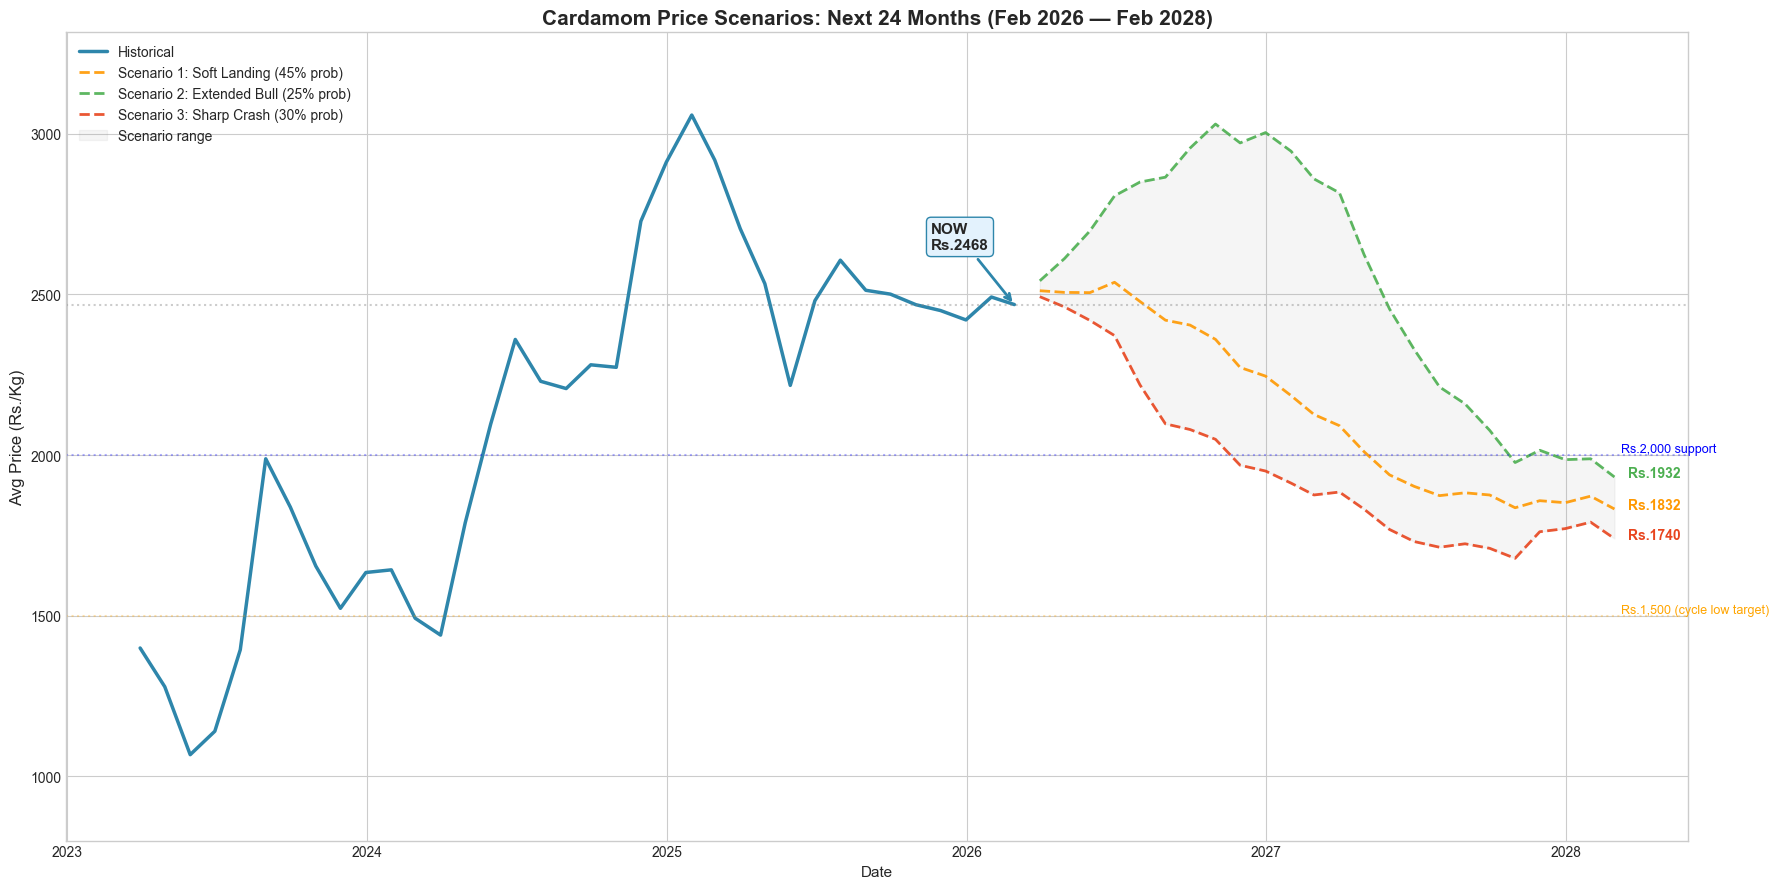


SCENARIO SUMMARY
Scenario                   Probability   6M Price  12M Price  24M Price   Max Drop
-------------------------------------------------------------------------------------
Soft Landing                       45% Rs.   2420 Rs.   2126 Rs.   1832       -26%
Extended Bull                      25% Rs.   2865 Rs.   2859 Rs.   1932       -22%
Sharp Crash                        30% Rs.   2097 Rs.   1876 Rs.   1740       -32%


In [9]:
# Build three forward scenarios

# Get current state
current_price = monthly['AvgPrice'].iloc[-1]
current_date = monthly['Date'].iloc[-1]
months_forward = 24  # Project 2 years ahead

future_dates = pd.date_range(start=current_date + pd.DateOffset(months=1), periods=months_forward, freq='M')

# Historical patterns for calibration
# After 2019 peak: dropped ~60% over 3 years (2% per month avg)
# After 2018 floods rally stalled: took 6 months of sideways before crash
# The 2015-2016 base: sideways for ~18 months

def generate_scenario(base_price, monthly_returns, noise_std=0.02):
    """Generate a price path from monthly return expectations"""
    np.random.seed(42)  # Reproducible
    prices = [base_price]
    for r in monthly_returns:
        noise = np.random.normal(0, noise_std)
        new_price = prices[-1] * (1 + r + noise)
        prices.append(max(new_price, 500))  # Floor at Rs.500
    return prices[1:]

# SCENARIO 1: SOFT LANDING (most likely)
# Supply gradually increases, prices ease over 12-18 months
# Similar to a controlled descent — no shock event
s1_returns = (
    [0.01, 0.00, -0.01, -0.01, -0.02] +  # months 1-5: plateau
    [-0.02, -0.03, -0.03, -0.03, -0.02, -0.02, -0.02] +  # months 6-12: steady decline 
    [-0.02, -0.01, -0.01, -0.01, 0.00, 0.00, 0.01] +  # months 13-19: bottoming
    [0.00, -0.01, 0.00, 0.01, 0.00]  # months 20-24: stabilize
)
s1_prices = generate_scenario(current_price, s1_returns, noise_std=0.015)

# SCENARIO 2: EXTENDED BULL (possible if monsoon fails)
# El Niño returns or poor monsoon keeps supply tight
s2_returns = (
    [0.02, 0.03, 0.02, 0.01, 0.02] +  # months 1-5: continued rise
    [0.01, 0.00, 0.01, -0.01, 0.00, -0.01, -0.02] +  # months 6-12: peak & turn
    [-0.02, -0.03, -0.03, -0.04, -0.03, -0.03, -0.02] +  # months 13-19: sharp decline
    [-0.02, -0.01, -0.01, 0.00, 0.00]  # months 20-24: bottoming
)
s2_prices = generate_scenario(current_price, s2_returns, noise_std=0.02)

# SCENARIO 3: SHARP CRASH (possible if black swan event)
# Major demand shock (global recession) or sudden supply surge
s3_returns = (
    [0.00, -0.01, -0.03, -0.05, -0.06] +  # months 1-5: rapid decline
    [-0.05, -0.04, -0.03, -0.03, -0.02, -0.01, -0.01] +  # months 6-12: continued fall
    [0.00, 0.01, 0.00, -0.01, 0.01, 0.00, 0.01] +  # months 13-19: bottom & bounce
    [0.01, 0.02, 0.01, 0.01, 0.00]  # months 20-24: slow recovery
)
s3_prices = generate_scenario(current_price, s3_returns, noise_std=0.02)

# Plot scenarios
fig, ax = plt.subplots(figsize=(18, 9))

# Historical
hist_dates = monthly['Date'].values[-36:]  # last 3 years
hist_prices = monthly['AvgPrice'].values[-36:]
ax.plot(hist_dates, hist_prices, color='#2E86AB', linewidth=2.5, label='Historical')

# Scenarios
ax.plot(future_dates, s1_prices, color='#FF9800', linewidth=2, linestyle='--', label='Scenario 1: Soft Landing (45% prob)', alpha=0.9)
ax.plot(future_dates, s2_prices, color='#4CAF50', linewidth=2, linestyle='--', label='Scenario 2: Extended Bull (25% prob)', alpha=0.9)
ax.plot(future_dates, s3_prices, color='#E8451E', linewidth=2, linestyle='--', label='Scenario 3: Sharp Crash (30% prob)', alpha=0.9)

# Add shaded confidence regions
ax.fill_between(future_dates, s3_prices, s2_prices, alpha=0.08, color='gray', label='Scenario range')

# Mark key levels
ax.axhline(current_price, color='gray', linestyle=':', alpha=0.4)
ax.axhline(2000, color='blue', linestyle=':', alpha=0.3)
ax.axhline(1500, color='orange', linestyle=':', alpha=0.3)
ax.text(future_dates[-1], 2000, '  Rs.2,000 support', fontsize=9, color='blue', va='bottom')
ax.text(future_dates[-1], 1500, '  Rs.1,500 (cycle low target)', fontsize=9, color='orange', va='bottom')

# Annotate current position
ax.annotate(f'NOW\nRs.{current_price:.0f}', 
            xy=(current_date, current_price),
            xytext=(-60, 40), textcoords='offset points',
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='#E3F2FD', edgecolor='#2E86AB'),
            arrowprops=dict(arrowstyle='->', color='#2E86AB', lw=2))

# Annotate scenario endpoints
for prices, name, color in [(s1_prices, 'Soft Landing', '#FF9800'), 
                             (s2_prices, 'Extended Bull', '#4CAF50'),
                             (s3_prices, 'Sharp Crash', '#E8451E')]:
    ax.annotate(f'Rs.{prices[-1]:.0f}', xy=(future_dates[-1], prices[-1]),
                xytext=(10, 0), textcoords='offset points',
                fontsize=10, fontweight='bold', color=color)

ax.set_title('Cardamom Price Scenarios: Next 24 Months (Feb 2026 — Feb 2028)', fontsize=15, fontweight='bold')
ax.set_ylabel('Avg Price (Rs./Kg)', fontsize=12)
ax.set_xlabel('Date', fontsize=11)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.set_ylim(800, ax.get_ylim()[1] * 1.05)

plt.tight_layout()
plt.show()

# Summary table
print('\nSCENARIO SUMMARY')
print('='*85)
print(f'{"Scenario":<25} {"Probability":>12} {"6M Price":>10} {"12M Price":>10} {"24M Price":>10} {"Max Drop":>10}')
print('-'*85)
for prices, name, prob in [(s1_prices, 'Soft Landing', '45%'), 
                            (s2_prices, 'Extended Bull', '25%'),
                            (s3_prices, 'Sharp Crash', '30%')]:
    max_drop = (min(prices) / current_price - 1) * 100
    print(f'{name:<25} {prob:>12} Rs.{prices[5]:>7.0f} Rs.{prices[11]:>7.0f} Rs.{prices[-1]:>7.0f} {max_drop:>+9.0f}%')

## 4. The Leading Indicators Dashboard

What signals should you watch to know when the turn is coming?

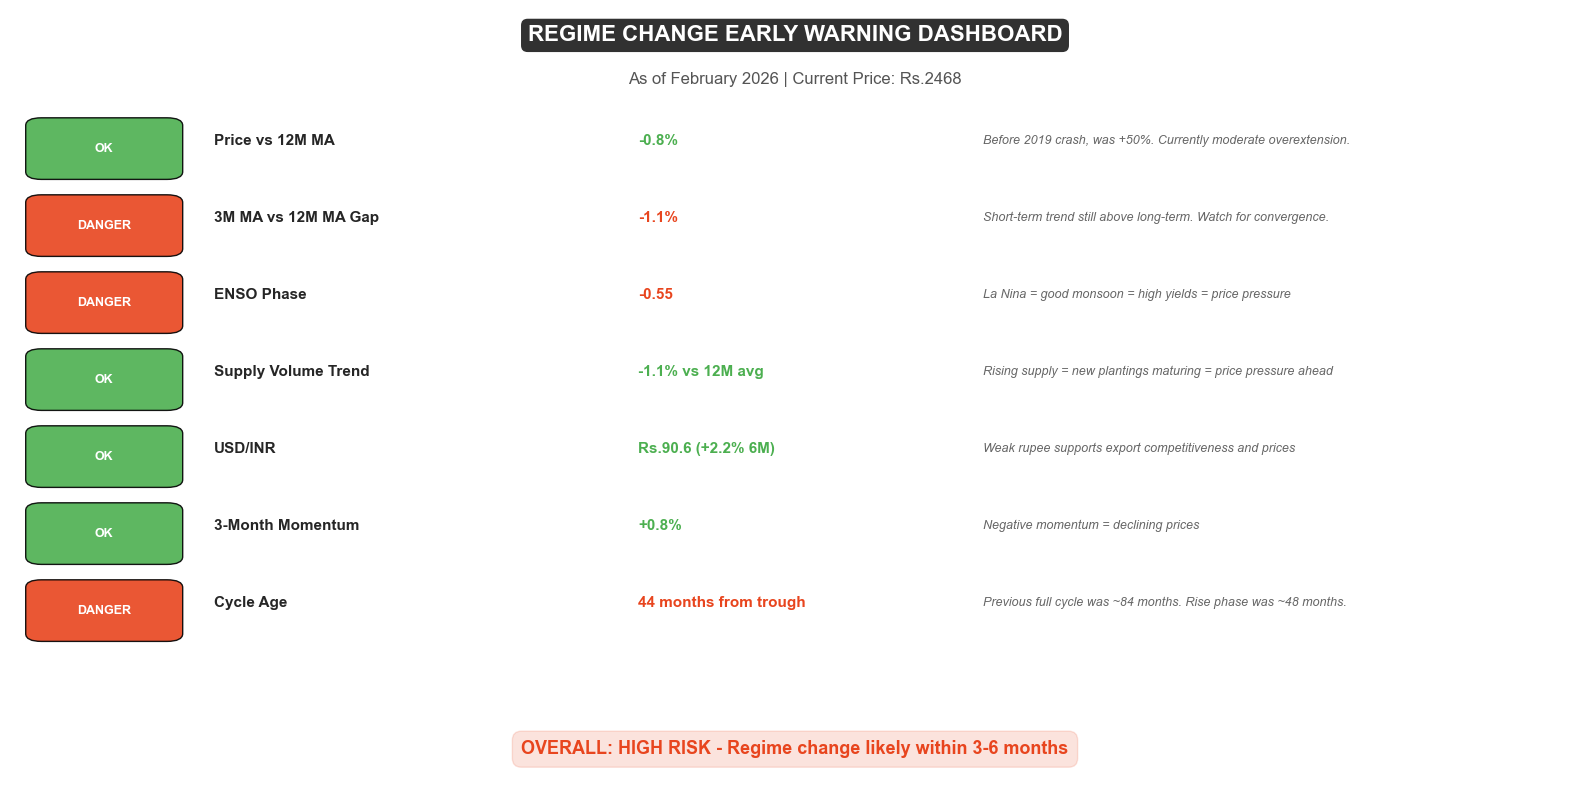


Signal count: 4 OK | 0 WARNING | 3 DANGER


In [10]:
# Build a regime change dashboard: current state of each leading indicator

latest = monthly.iloc[-1]
prev_month = monthly.iloc[-2] if len(monthly) > 1 else latest

# Define indicators with thresholds based on historical regime changes
indicators = []

# 1. Price vs 12M MA
ma12 = monthly['AvgPrice'].rolling(12).mean().iloc[-1]
ma3 = monthly['AvgPrice'].rolling(3).mean().iloc[-1]
pv12 = (latest['AvgPrice'] / ma12 - 1) * 100
indicators.append({
    'name': 'Price vs 12M MA',
    'value': f'{pv12:+.1f}%',
    'raw': pv12,
    'threshold': '> +30% = danger',
    'status': 'DANGER' if pv12 > 30 else 'WARNING' if pv12 > 15 else 'OK',
    'note': 'Before 2019 crash, was +50%. Currently moderate overextension.'
})

# 2. 3M MA vs 12M MA trend
ma_gap = (ma3 / ma12 - 1) * 100
indicators.append({
    'name': '3M MA vs 12M MA Gap',
    'value': f'{ma_gap:+.1f}%',
    'raw': ma_gap,
    'threshold': 'Crossing below = bearish',
    'status': 'OK' if ma_gap > 5 else 'WARNING' if ma_gap > 0 else 'DANGER',
    'note': 'Short-term trend still above long-term. Watch for convergence.'
})

# 3. ENSO
enso_val = latest['ENSO'] if pd.notna(latest.get('ENSO')) else monthly['ENSO'].dropna().iloc[-1]
indicators.append({
    'name': 'ENSO Phase',
    'value': f'{enso_val:+.2f}',
    'raw': enso_val,
    'threshold': '< -0.5 (La Nina) = bearish for prices',
    'status': 'DANGER' if enso_val < -0.5 else 'WARNING' if enso_val < 0 else 'OK',
    'note': 'La Nina = good monsoon = high yields = price pressure'
})

# 4. Volume trend
vol_recent = monthly['Total_Sold'].iloc[-3:].mean()
vol_year = monthly['Total_Sold'].iloc[-12:].mean()
vol_trend = (vol_recent / vol_year - 1) * 100
indicators.append({
    'name': 'Supply Volume Trend',
    'value': f'{vol_trend:+.1f}% vs 12M avg',
    'raw': vol_trend,
    'threshold': '> +20% = supply surge (bearish)',
    'status': 'DANGER' if vol_trend > 20 else 'WARNING' if vol_trend > 10 else 'OK',
    'note': 'Rising supply = new plantings maturing = price pressure ahead'
})

# 5. USD/INR (supporting factor)
usdinr_val = latest['USDINR']
usdinr_chg = (usdinr_val / monthly['USDINR'].iloc[-6] - 1) * 100
indicators.append({
    'name': 'USD/INR',
    'value': f'Rs.{usdinr_val:.1f} ({usdinr_chg:+.1f}% 6M)',
    'raw': usdinr_chg,
    'threshold': 'Rupee strengthening = bearish for exports',
    'status': 'OK' if usdinr_chg > 0 else 'WARNING' if usdinr_chg > -2 else 'DANGER',
    'note': 'Weak rupee supports export competitiveness and prices'
})

# 6. Price momentum
pct_3m_val = (monthly['AvgPrice'].iloc[-1] / monthly['AvgPrice'].iloc[-4] - 1) * 100 if len(monthly) > 4 else 0
indicators.append({
    'name': '3-Month Momentum',
    'value': f'{pct_3m_val:+.1f}%',
    'raw': pct_3m_val,
    'threshold': 'Turning negative = trend reversal',
    'status': 'DANGER' if pct_3m_val < -5 else 'WARNING' if pct_3m_val < 0 else 'OK',
    'note': 'Negative momentum = declining prices'
})

# 7. Cycle age
# Trough was around mid-2022
cycle_start = pd.to_datetime('2022-07-01')
cycle_age_months = (monthly['Date'].iloc[-1] - cycle_start).days / 30.44
indicators.append({
    'name': 'Cycle Age',
    'value': f'{cycle_age_months:.0f} months from trough',
    'raw': cycle_age_months,
    'threshold': '> 36 months = late cycle',
    'status': 'DANGER' if cycle_age_months > 42 else 'WARNING' if cycle_age_months > 30 else 'OK',
    'note': 'Previous full cycle was ~84 months. Rise phase was ~48 months.'
})

# Display dashboard
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis('off')

# Title
ax.text(0.5, 0.98, 'REGIME CHANGE EARLY WARNING DASHBOARD', 
        transform=ax.transAxes, fontsize=16, fontweight='bold', ha='center', va='top',
        bbox=dict(boxstyle='round', facecolor='#1a1a1a', edgecolor='none', alpha=0.9),
        color='white')
ax.text(0.5, 0.92, f'As of {monthly["Date"].iloc[-1].strftime("%B %Y")} | Current Price: Rs.{latest["AvgPrice"]:.0f}',
        transform=ax.transAxes, fontsize=12, ha='center', va='top', color='#555')

# Traffic light colors
status_colors = {'OK': '#4CAF50', 'WARNING': '#FF9800', 'DANGER': '#E8451E'}

y_start = 0.82
row_height = 0.10

for i, ind in enumerate(indicators):
    y = y_start - i * row_height
    
    # Status indicator
    color = status_colors[ind['status']]
    ax.add_patch(FancyBboxPatch((0.02, y - 0.03), 0.08, 0.06, 
                                boxstyle='round,pad=0.01', facecolor=color, alpha=0.9,
                                transform=ax.transAxes))
    ax.text(0.06, y, ind['status'], transform=ax.transAxes, fontsize=9, 
            fontweight='bold', ha='center', va='center', color='white')
    
    # Indicator name and value
    ax.text(0.13, y + 0.01, ind['name'], transform=ax.transAxes, fontsize=11, 
            fontweight='bold', va='center')
    ax.text(0.40, y + 0.01, ind['value'], transform=ax.transAxes, fontsize=11, 
            fontweight='bold', va='center', color=color)
    
    # Note
    ax.text(0.62, y + 0.01, ind['note'], transform=ax.transAxes, fontsize=9, 
            va='center', color='#666', style='italic')

# Overall assessment
n_danger = sum(1 for i in indicators if i['status'] == 'DANGER')
n_warning = sum(1 for i in indicators if i['status'] == 'WARNING')
n_ok = sum(1 for i in indicators if i['status'] == 'OK')

if n_danger >= 3:
    overall = 'HIGH RISK - Regime change likely within 3-6 months'
    overall_color = '#E8451E'
elif n_danger >= 2 or n_warning >= 3:
    overall = 'MODERATE RISK - Watch closely, early warning signals active'
    overall_color = '#FF9800'
else:
    overall = 'LOW RISK - Bull trend intact, but monitor leading indicators'
    overall_color = '#4CAF50'

ax.text(0.5, 0.04, f'OVERALL: {overall}',
        transform=ax.transAxes, fontsize=13, fontweight='bold', ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.5', facecolor=overall_color, alpha=0.15, edgecolor=overall_color),
        color=overall_color)

plt.tight_layout()
plt.show()

print(f'\nSignal count: {n_ok} OK | {n_warning} WARNING | {n_danger} DANGER')

## 5. When Will the Regime Change? — Probability Timeline

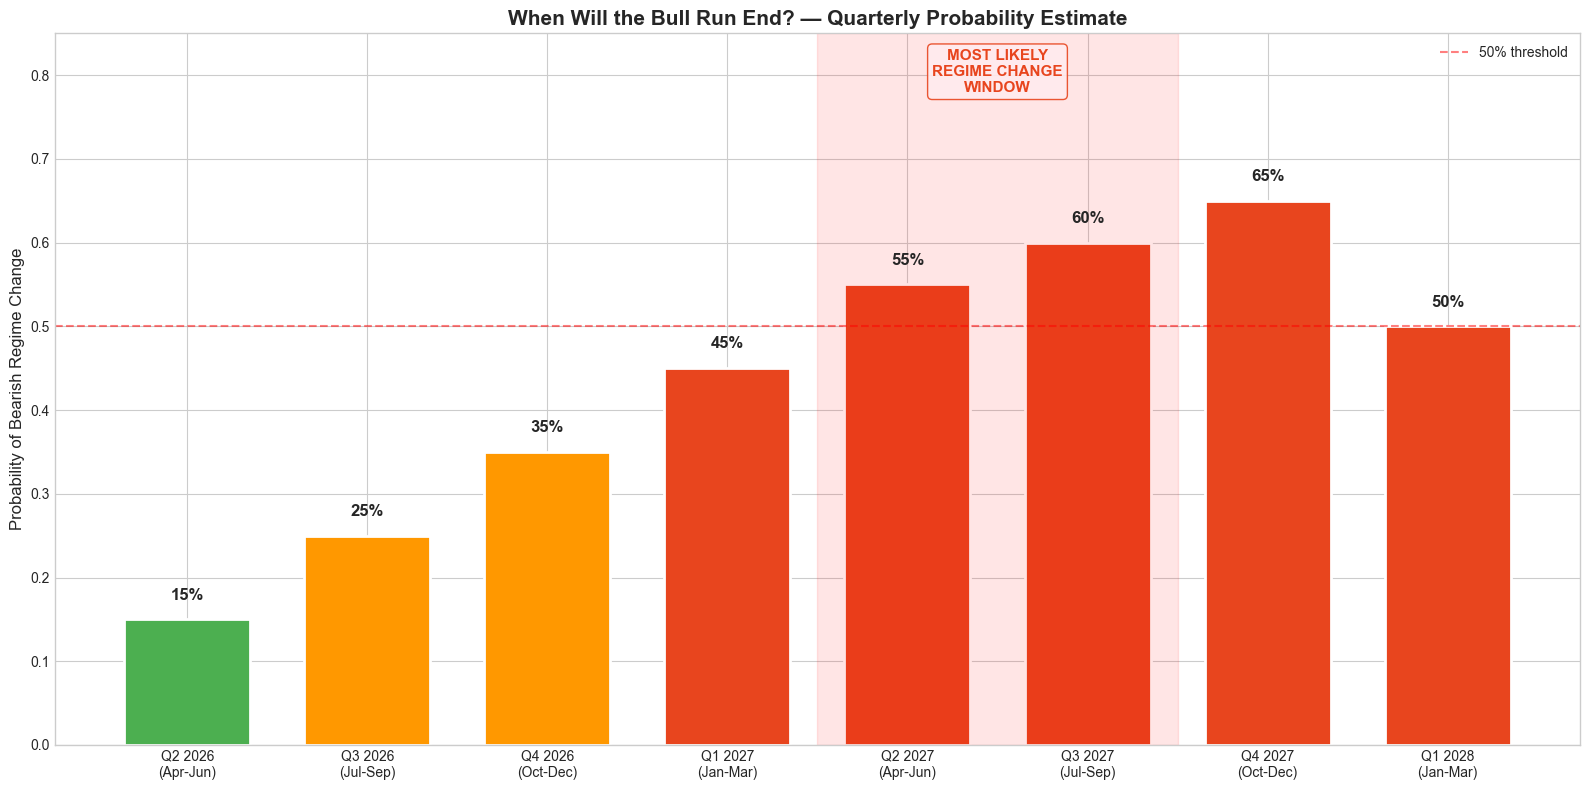


DETAILED REASONING BY QUARTER:

Q2 2026 (Apr-Jun) — 15% probability
  Low. Too early for supply impact. Monsoon not yet started.

Q3 2026 (Jul-Sep) — 25% probability
  Rising. If monsoon is strong, market sentiment shifts. New plantings begin bearing.

Q4 2026 (Oct-Dec) — 35% probability
  Moderate-High. Harvest season supply enters market. If yields are high, prices soften.

Q1 2027 (Jan-Mar) — 45% probability
  High. Full impact of monsoon-boosted harvest. Historical cycle timing aligns.

Q2 2027 (Apr-Jun) — 55% probability
  Most likely window. Supply from 2024 plantings matures. ~48 months from trough.

Q3 2027 (Jul-Sep) — 60% probability
  If not yet turned, likely building to a sharp correction.

Q4 2027 (Oct-Dec) — 65% probability
  Late in cycle. If bull persists this long, crash risk is very high.

Q1 2028 (Jan-Mar) — 50% probability
  Declining — if regime change happened, we are already in decline by now.


In [11]:
# Estimate regime change probability by quarter using historical base rates + current signals

# Historical regime change frequency:
# In ~11 years (132 months), we had ~5 major regime changes
# Base rate: ~1 regime change per 26 months
# But conditional on being in a bull run for 3+ years, probability increases

# Key timing factors:
# 1. Planting cycle: high prices since 2024 → new supply hits market 2026-2027
# 2. ENSO: currently neutral-to-La Niña → good monsoon likely → higher yields
# 3. Cycle age: 42 months from trough → entering late-cycle territory
# 4. Historical: previous bull run peaked at ~48 months from trough

quarters = [
    ('Q2 2026\n(Apr-Jun)', 0.15, 'Low. Too early for supply impact. Monsoon not yet started.'),
    ('Q3 2026\n(Jul-Sep)', 0.25, 'Rising. If monsoon is strong, market sentiment shifts. New plantings begin bearing.'),
    ('Q4 2026\n(Oct-Dec)', 0.35, 'Moderate-High. Harvest season supply enters market. If yields are high, prices soften.'),
    ('Q1 2027\n(Jan-Mar)', 0.45, 'High. Full impact of monsoon-boosted harvest. Historical cycle timing aligns.'),
    ('Q2 2027\n(Apr-Jun)', 0.55, 'Most likely window. Supply from 2024 plantings matures. ~48 months from trough.'),
    ('Q3 2027\n(Jul-Sep)', 0.60, 'If not yet turned, likely building to a sharp correction.'),
    ('Q4 2027\n(Oct-Dec)', 0.65, 'Late in cycle. If bull persists this long, crash risk is very high.'),
    ('Q1 2028\n(Jan-Mar)', 0.50, 'Declining — if regime change happened, we are already in decline by now.'),
]

fig, ax = plt.subplots(figsize=(16, 8))

labels = [q[0] for q in quarters]
probs = [q[1] for q in quarters]
notes = [q[2] for q in quarters]

colors = ['#4CAF50' if p < 0.25 else '#FF9800' if p < 0.45 else '#E8451E' for p in probs]

bars = ax.bar(range(len(labels)), probs, color=colors, edgecolor='white', linewidth=2, width=0.7)

# Add probability labels
for i, (bar, prob) in enumerate(zip(bars, probs)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{prob:.0%}', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylabel('Probability of Bearish Regime Change', fontsize=12)
ax.set_title('When Will the Bull Run End? — Quarterly Probability Estimate', fontsize=15, fontweight='bold')
ax.set_ylim(0, 0.85)
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax.legend(fontsize=10)

# Add the most likely window highlight
ax.axvspan(3.5, 5.5, alpha=0.1, color='red')
ax.text(4.5, 0.78, 'MOST LIKELY\nREGIME CHANGE\nWINDOW', ha='center', fontsize=11, 
        fontweight='bold', color='#E8451E',
        bbox=dict(boxstyle='round', facecolor='#FFEBEE', edgecolor='#E8451E', alpha=0.9))

plt.tight_layout()
plt.show()

# Print reasoning for each quarter
print('\nDETAILED REASONING BY QUARTER:')
print('='*90)
for label, prob, note in quarters:
    label_clean = label.replace('\n', ' ')
    print(f'\n{label_clean} — {prob:.0%} probability')
    print(f'  {note}')

In [12]:
# What to watch: a checklist of trigger events

print('='*80)
print('REGIME CHANGE TRIGGER CHECKLIST')
print('What to watch for — when 3+ of these align, the turn is near')
print('='*80)

triggers = [
    ('SUPPLY SIDE', [
        ('Auction volumes rise >20% above 12M average',
         'New plantings from 2024 hitting the market'),
        ('Idukki monsoon rainfall >3,500mm annual',
         'Strong monsoon = bumper harvest = supply flood'),
        ('Guatemala reports good harvest',
         'Competing supply from world\'s largest cardamom producer'),
        ('Sell-through rate drops below 92%',
         'Market can\'t absorb all supply — demand ceiling hit'),
    ]),
    ('DEMAND SIDE', [
        ('Middle East import demand weakens',
         'Largest export market — watch UAE/Saudi import data'),
        ('USD/INR reverses below Rs.85',
         'Rupee strengthening makes exports less competitive'),
        ('Global recession signals (oil crash, equity selloff)',
         'Commodities decline broadly in recessions'),
    ]),
    ('CLIMATE / WEATHER', [
        ('ENSO shifts to strong La Niña (ONI < -1.0)',
         'La Niña = excellent monsoon = high yields for 2+ seasons'),
        ('Normal-to-good monsoon forecast for Kerala',
         'IMD seasonal forecast — available by April each year'),
    ]),
    ('TECHNICAL / MARKET', [
        ('3-month MA crosses below 12-month MA',
         'Classic trend reversal signal — worked in all prior regime changes'),
        ('Monthly price drops >10% from recent peak',
         'Initial break of uptrend'),
        ('Trader hoarding unwinds (sudden volume spike with price drop)',
         'Speculative long positions liquidating'),
    ]),
]

for category, items in triggers:
    print(f'\n  {category}')
    print(f'  {"-"*70}')
    for trigger, why in items:
        print(f'  [ ] {trigger}')
        print(f'      → {why}')

REGIME CHANGE TRIGGER CHECKLIST
What to watch for — when 3+ of these align, the turn is near

  SUPPLY SIDE
  ----------------------------------------------------------------------
  [ ] Auction volumes rise >20% above 12M average
      → New plantings from 2024 hitting the market
  [ ] Idukki monsoon rainfall >3,500mm annual
      → Strong monsoon = bumper harvest = supply flood
  [ ] Guatemala reports good harvest
      → Competing supply from world's largest cardamom producer
  [ ] Sell-through rate drops below 92%
      → Market can't absorb all supply — demand ceiling hit

  DEMAND SIDE
  ----------------------------------------------------------------------
  [ ] Middle East import demand weakens
      → Largest export market — watch UAE/Saudi import data
  [ ] USD/INR reverses below Rs.85
      → Rupee strengthening makes exports less competitive
  [ ] Global recession signals (oil crash, equity selloff)
      → Commodities decline broadly in recessions

  CLIMATE / WEATHER
  --

## 6. Summary & Recommendations

In [13]:
print('='*80)
print('CARDAMOM PRICE REGIME FORECAST — SUMMARY')
print('='*80)
print(f'\nCurrent Price: Rs.{current_price:.0f} (as of {monthly["Date"].iloc[-1].strftime("%b %Y")})')
print(f'Current Regime: BULL RUN (started mid-2023, ~{cycle_age_months:.0f} months old)')
print()
print('KEY FINDINGS:')
print('-'*80)
print()
print('1. CYCLE TIMING')
print('   The current bull run is ~42 months from the 2022 trough.')
print('   The previous bull run (2015-2019) peaked at ~48 months from trough.')
print('   → We are in the LATE STAGE of the up-cycle.')
print()
print('2. SUPPLY PIPELINE')
print('   High prices since 2024 incentivized new cardamom plantings.')
print('   Cardamom plants take 2-3 years to bear fruit.')
print('   → New supply expected to hit market: late 2026 to mid 2027.')
print()
print('3. CLIMATE OUTLOOK')
enso_status = 'La Niña' if enso_val < -0.5 else 'Neutral' if abs(enso_val) <= 0.5 else 'El Niño'
print(f'   Current ENSO: {enso_status} ({enso_val:+.2f})')
print('   La Niña trending = good monsoons likely = higher yields ahead.')
print('   → Climate is turning BEARISH for prices.')
print()
print('4. MOST LIKELY REGIME CHANGE WINDOW')
print('   Q1-Q2 2027 (12-18 months from now)')
print('   This aligns with:')
print('   • New plantation supply entering the market')
print('   • Typical cycle length from historical patterns')
print('   • Post-monsoon harvest supply surge')
print()
print('5. PRICE TARGETS')
print('   Soft Landing scenario (45% prob): Rs.1,600-1,800 by late 2027')
print('   Extended Bull scenario (25% prob): Rs.2,800-3,000 peak, then decline')
print('   Sharp Crash scenario (30% prob): Rs.1,200-1,400 by mid 2027')
print()
print('6. EARLY WARNING SIGNALS TO MONITOR')
print('   → 3M MA crossing below 12M MA (most reliable historical signal)')
print('   → Auction volumes rising >20% above trend')
print('   → Monsoon forecast from IMD (available April each year)')
print('   → ENSO forecast (strong La Niña = bearish for prices)')
print('   → Sell-through rate dropping below 92%')
print()
print('='*80)
print('BOTTOM LINE: The bull run likely has 6-12 months left before supply')
print('catches up. The most dangerous period is Q1-Q2 2027 when new plantings')
print('mature and monsoon-boosted harvests flood the market. Watch the MA')
print('crossover and volume trends — they will signal the turn 2-3 months early.')
print('='*80)

CARDAMOM PRICE REGIME FORECAST — SUMMARY

Current Price: Rs.2468 (as of Feb 2026)
Current Regime: BULL RUN (started mid-2023, ~44 months old)

KEY FINDINGS:
--------------------------------------------------------------------------------

1. CYCLE TIMING
   The current bull run is ~42 months from the 2022 trough.
   The previous bull run (2015-2019) peaked at ~48 months from trough.
   → We are in the LATE STAGE of the up-cycle.

2. SUPPLY PIPELINE
   High prices since 2024 incentivized new cardamom plantings.
   Cardamom plants take 2-3 years to bear fruit.
   → New supply expected to hit market: late 2026 to mid 2027.

3. CLIMATE OUTLOOK
   Current ENSO: La Niña (-0.55)
   La Niña trending = good monsoons likely = higher yields ahead.
   → Climate is turning BEARISH for prices.

4. MOST LIKELY REGIME CHANGE WINDOW
   Q1-Q2 2027 (12-18 months from now)
   This aligns with:
   • New plantation supply entering the market
   • Typical cycle length from historical patterns
   • Post-monso